<a href="https://colab.research.google.com/github/splendiferousnoctifer/qrFinderPattern/blob/codeCreation/qr_finder_pattern.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# QR Finder Patterns from Video


## Setup


In [ ]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import matplotlib.pyplot as plt
import numpy as np
import PIL
import io
import html
import time
import math

In [ ]:
def imshow(image, *args, **kwargs):
    """A replacement for cv2.imshow() for use in Jupyter notebooks using matplotlib.

        Args:
          image : np.ndarray. shape (N, M) or (N, M, 1) is an NxM grayscale image. shape
            (N, M, 3) is an NxM BGR color image. 
    """
    if len(image.shape) == 3:
      # Height, width, channels
      # Assume BGR, do a conversion  
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Draw the image
    plt.imshow(image, *args, **kwargs)
    # We'll also disable drawing the axes and tick marks in the plot, since it's actually an image
    plt.axis('off')
    # Make sure it outputs
    # plt.show()
    
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

## QR Finder Pattern extractor


In [ ]:
BLUR_VALUE = 3
SQUARE_TOLERANCE = 0.15
AREA_TOLERANCE = 0.15
DISTANCE_TOLERANCE = 0.25
WARP_DIM = 300
SMALL_DIM = 29


def count_children(hierarchy, parent, inner=False):
    """
    Counts children in hierarchy to check if 
    """

    if parent == -1:
        return 0
    elif not inner:
        return count_children(hierarchy, hierarchy[parent][2], True)
    return 1 + count_children(hierarchy, hierarchy[parent][0], True) + count_children(hierarchy, hierarchy[parent][2], True)


def has_square_parent(hierarchy, squares, parent):
    if hierarchy[parent][3] == -1:
        return False
    if hierarchy[parent][3] in squares:
        return True
    return has_square_parent(hierarchy, squares, hierarchy[parent][3])


def get_center(c):
    m = cv2.moments(c)
    return [int(m["m10"] / m["m00"]), int(m["m01"] / m["m00"])]


def get_angle(p1, p2):
    x_diff = p2[0] - p1[0]
    y_diff = p2[1] - p1[1]
    return math.degrees(math.atan2(y_diff, x_diff))


def get_midpoint(p1, p2):
    return [(p1[0] + p2[0]) / 2, (p1[1] + p2[1]) / 2]


def get_farthest_points(contour, center):
    distances = []
    distances_to_points = {}
    for point in contour:
        point = point[0]
        d = math.hypot(point[0] - center[0], point[1] - center[1])
        distances.append(d)
        distances_to_points[d] = point
    distances = sorted(distances)
    return [distances_to_points[distances[-1]], distances_to_points[distances[-2]]]


def line_intersection(line1, line2):
    x_diff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    y_diff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(x_diff, y_diff)
    if div == 0:
        return [-1, -1]

    d = (det(*line1), det(*line2))
    x = det(d, x_diff) / div
    y = det(d, y_diff) / div
    return [int(x), int(y)]


def extend(a, b, length, int_represent=False):
    length_ab = math.sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2)
    if length_ab * length <= 0:
        return b
    result = [b[0] + (b[0] - a[0]) / length_ab * length, b[1] + (b[1] - a[1]) / length_ab * length]
    if int_represent:
        return [int(result[0]), int(result[1])]
    else:
        return result


def extract(frame, debug=False):
    #output = frame.copy()
    output = np.zeros([frame.shape[0],frame.shape[1],4], dtype=np.uint8)

    # Remove noise and unnecessary contours from frame
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray = cv2.bilateralFilter(gray, 11, 17, 17)
    gray = cv2.GaussianBlur(gray, (BLUR_VALUE, BLUR_VALUE), 0)
    edged = cv2.Canny(gray, 30, 200)

    contours, hierarchy = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    squares = []
    square_indices = []

    i = 0
    for c in contours:
        # Approximate the contour
        peri = cv2.arcLength(c, True)
        area = cv2.contourArea(c)
        approx = cv2.approxPolyDP(c, 0.03 * peri, True)

        # Find all quadrilateral contours
        if len(approx) == 4:
            # Determine if quadrilateral is a square within SQUARE_TOLERANCE
            if area > 25 and 1 - SQUARE_TOLERANCE < math.fabs((peri / 4) ** 2) / area < 1 + SQUARE_TOLERANCE and count_children(hierarchy[0], i) >= 2 and has_square_parent(hierarchy[0], square_indices, i) is False:
                squares.append(approx)
                square_indices.append(i)
        i += 1

    main_corners = []
    east_corners = []
    south_corners = []
    tiny_squares = []
    rectangles = []
    # Determine if squares are QR codes
    for square in squares:
        area = cv2.contourArea(square)
        center = get_center(square)
        peri = cv2.arcLength(square, True)

        similar = []
        tiny = []
        for other in squares:
            if square[0][0][0] != other[0][0][0]:
                # Determine if square is similar to other square within AREA_TOLERANCE
                if math.fabs(area - cv2.contourArea(other)) / max(area, cv2.contourArea(other)) <= AREA_TOLERANCE:
                    similar.append(other)
                elif peri / 4 / 2 > cv2.arcLength(other, True) / 4:
                    tiny.append(other)

        if len(similar) >= 2:
            distances = []
            distances_to_contours = {}
            for sim in similar:
                sim_center = get_center(sim)
                d = math.hypot(sim_center[0] - center[0], sim_center[1] - center[1])
                distances.append(d)
                distances_to_contours[d] = sim
            distances = sorted(distances)
            closest_a = distances[-1]
            closest_b = distances[-2]

            # Determine if this square is the top left QR code indicator
            if max(closest_a, closest_b) < cv2.arcLength(square, True) * 2.5 and math.fabs(closest_a - closest_b) / max(closest_a, closest_b) <= DISTANCE_TOLERANCE:
                # Determine placement of other indicators (even if code is rotated)
                angle_a = get_angle(get_center(distances_to_contours[closest_a]), center)
                angle_b = get_angle(get_center(distances_to_contours[closest_b]), center)
                if angle_a < angle_b or (angle_b < -90 and angle_a > 0):
                    east = distances_to_contours[closest_a]
                    south = distances_to_contours[closest_b]
                else:
                    east = distances_to_contours[closest_b]
                    south = distances_to_contours[closest_a]
                midpoint = get_midpoint(get_center(east), get_center(south))
                # Determine location of fourth corner
                # Find closest tiny indicator if possible
                min_dist = 10000
                t = []
                tiny_found = False
                if len(tiny) > 0:
                    for tin in tiny:
                        tin_center = get_center(tin)
                        d = math.hypot(tin_center[0] - midpoint[0], tin_center[1] - midpoint[1])
                        if d < min_dist:
                            min_dist = d
                            t = tin
                    tiny_found = len(t) > 0 and min_dist < peri

                diagonal = peri / 4 * 1.41421

                if tiny_found:
                    # Easy, corner is just a few blocks away from the tiny indicator
                    tiny_squares.append(t)
                    offset = extend(midpoint, get_center(t), peri / 4 * 1.41421)
                else:
                    # No tiny indicator found, must extrapolate corner based off of other corners instead
                    farthest_a = get_farthest_points(distances_to_contours[closest_a], center)
                    farthest_b = get_farthest_points(distances_to_contours[closest_b], center)
                    # Use sides of indicators to determine fourth corner
                    offset = line_intersection(farthest_a, farthest_b)
                    if offset[0] == -1:
                        # Error, extrapolation failed, go on to next possible code
                        continue
                    offset = extend(midpoint, offset, peri / 4 / 7)
                    if debug:
                        cv2.line(output, (farthest_a[0][0], farthest_a[0][1]), (farthest_a[1][0], farthest_a[1][1]), (0, 0, 255), 4)
                        cv2.line(output, (farthest_b[0][0], farthest_b[0][1]), (farthest_b[1][0], farthest_b[1][1]), (0, 0, 255), 4)

                # Append rectangle, offsetting to farthest borders
                rectangles.append([extend(midpoint, center, diagonal / 2, True), extend(midpoint, get_center(distances_to_contours[closest_b]), diagonal / 2, True), offset, extend(midpoint, get_center(distances_to_contours[closest_a]), diagonal / 2, True)])
                east_corners.append(east)
                south_corners.append(south)
                main_corners.append(square)

    codes = []
    i = 0
    for rect in rectangles:
        i += 1
        # Draw rectangle
        vrx = np.array((rect[0], rect[1], rect[2], rect[3]), np.int32)
        vrx = vrx.reshape((-1, 1, 2))
        cv2.polylines(output, [vrx], True, (0, 255, 255, 1), 2)
        # Warp codes and draw them
        wrect = np.zeros((4, 2), dtype="float32")
        wrect[0] = rect[0]
        wrect[1] = rect[1]
        wrect[2] = rect[2]
        wrect[3] = rect[3]
        dst = np.array([
            [0, 0],
            [WARP_DIM - 1, 0],
            [WARP_DIM - 1, WARP_DIM - 1],
            [0, WARP_DIM - 1]], dtype="float32")
        warp = cv2.warpPerspective(frame, cv2.getPerspectiveTransform(wrect, dst), (WARP_DIM, WARP_DIM))
        # Increase contrast
        warp = cv2.bilateralFilter(warp, 11, 17, 17)
        warp = cv2.cvtColor(warp, cv2.COLOR_BGR2GRAY)
        small = cv2.resize(warp, (SMALL_DIM, SMALL_DIM), 0, 0, interpolation=cv2.INTER_CUBIC)
        _, small = cv2.threshold(small, 100, 255, cv2.THRESH_BINARY)
        codes.append(small)
       # if debug:
            #cv2.imshow("Warped: " + str(i), small)

    if debug:
        # Draw debug information onto frame before outputting it
        cv2.drawContours(output, squares, -1, (5, 5, 5, 1), 2)
        cv2.drawContours(output, main_corners, -1, (0, 0, 128,1), 2)
        cv2.drawContours(output, east_corners, -1, (0, 128, 0,1), 2)
        cv2.drawContours(output, south_corners, -1, (128, 0, 0,1), 2)
        cv2.drawContours(output, tiny_squares, -1, (128, 128, 0,1), 2)

    return codes, output

In [ ]:
# initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

## Initialise Webcam Videos
- start a video stream using our webcam as input
- run each frame through detection
- create an overlay image
- overlay bbx video stream



In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

# Run

In [ ]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

   
    #extract code
    codes, frame = extract(img, False)
 
    
    frame[:,:,3] = (frame.max(axis = 2) > 0 ).astype(int) * 255

    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(frame)

    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

<IPython.core.display.Javascript object>

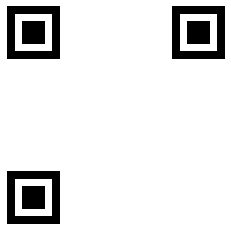

In [ ]:
imshow(cv2.cvtColor(codes[0], cv2.COLOR_BGR2RGB))